Following this:
https://www.tensorflow.org/tutorials/keras/regression

In [273]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import time

from tensorflow import keras
from keras import layers

from sklearn.metrics import mean_squared_error
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [274]:
tf.__version__

'2.8.0'

In [275]:
df = pd.read_csv('./data/ouput.csv')

In [276]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000168,2011-11-24 13:30:00,0.054
1,MAC000168,2011-11-24 14:00:00,0.178
2,MAC000168,2011-11-24 14:30:00,0.113
3,MAC000168,2011-11-24 15:00:00,0.068
4,MAC000168,2011-11-24 15:30:00,0.061


In [277]:
#ser ut som linear regression ikke funker med datetime så må converte (https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date)
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]

# comment hvis sjekke for 1 måned
# df['tstp'] = df['tstp'].apply(lambda x: time.mktime(x.timetuple()))
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], errors="coerce")

In [278]:
# id_training = 'MAC000150' 
# id_eval = 'MAC000152'

def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

In [279]:
dataset_house = find_household('MAC000150')

dataset_house = dataset_house.set_index('tstp')

dataset_house.head()

# prøver å korte ned på datasettet
train_dataset = dataset_house.loc['2013-01-01':'2013-02-01']
test_dataset = dataset_house.loc['2013-03-01':'2013-04-01']

# train_dataset = df.sample(frac=0.8, random_state=0)
# test_dataset = df.drop(train_dataset.index)


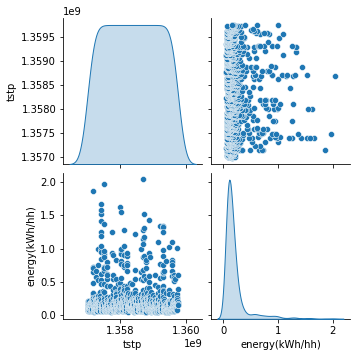

In [280]:
#reset index to plot and convert datetime
train_dataset = train_dataset.reset_index('tstp')
train_dataset['tstp'] = train_dataset['tstp'].apply(lambda x: time.mktime(x.timetuple()))
sns.pairplot(train_dataset[['LCLid','tstp', 'energy(kWh/hh)']], diag_kind='kde')

In [281]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tstp,1536.0,1.358376e+09,798388.777476,1.356995e+09,1.357686e+09,1.358376e+09,1.359067e+09,1.359758e+09
energy(kWh/hh),1536.0,2.023490e-01,0.235301,4.700000e-02,8.600000e-02,1.300000e-01,2.022500e-01,2.037000e+00


In [282]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('energy(kWh/hh)')
test_labels = test_features.pop('energy(kWh/hh)')

In [283]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
tstp,1.358376e+09,798388.777476
energy(kWh/hh),2.023490e-01,0.235301


In [284]:
train_dataset.head()

,tstp,LCLid,energy(kWh/hh)
0,1.356995e+09,MAC000150,0.160
1,1.356997e+09,MAC000150,0.147
2,1.356998e+09,MAC000150,0.183
3,1.357000e+09,MAC000150,0.154
4,1.357002e+09,MAC000150,0.161


dunno why normalization doesnt work, might be because of datetime (even tho i converted it to numeric?)

In [285]:
#Normalize with keras
normalizer = tf.keras.layers.Normalization(axis=0)
normalizer.adapt(np.array(train_features['tstp']))

In [286]:
normalizer.mean.numpy()

array([1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09,
       1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09,
       1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09,
       1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09,
       1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09, 1.358e+09,
       1.358e+09, 1.358e+09], dtype=float32)

In [287]:
#linear regression
energy = np.array(train_features['tstp'])
energy_normalizor = layers.Normalization(input_shape=[1,], axis=None)
energy_normalizor.adapt(energy)

In [288]:
#build the model
energy_model = tf.keras.Sequential([
    energy_normalizor,
    layers.Dense(units=1)
])

energy_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [289]:
energy_model.predict(energy[:10])

array([[1.308],
       [1.306],
       [1.304],
       [1.302],
       [1.301],
       [1.299],
       [1.297],
       [1.296],
       [1.294],
       [1.292]], dtype=float32)

In [290]:
energy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
loss='mean_absolute_error')

In [291]:
%%time
history = energy_model.fit(
    train_features['tstp'],
    train_labels,
    epochs=10,
    # Supress logging
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

CPU times: total: 875 ms
Wall time: 618 ms


In [292]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
5,0.123194,0.106837,5
6,0.126285,0.105562,6
7,0.120314,0.114845,7
8,0.119827,0.113529,8
9,0.121746,0.135893,9


In [293]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)

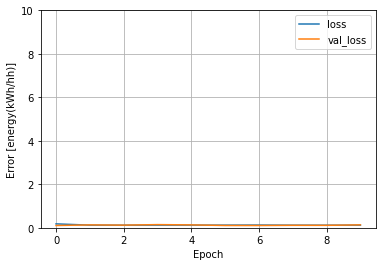

In [294]:
plot_loss(history)

In [295]:
test_features = test_features.reset_index('tstp')

In [296]:
#noe feil med index, siden jeg satte tstp til index på starten
#Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).
test_results = {}

test_results['energy_model'] = energy_model.evaluate(
    test_features['tstp'],
    test_labels, verbose=0)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = energy_model.predict(x)

In [ ]:
def plot_energy(x, y):
  plt.scatter(train_features['tstp'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('tstp')
  plt.ylabel('energy(kWh/hh)')
  plt.legend()

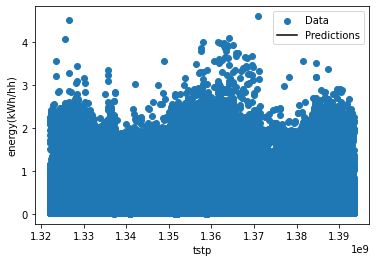

In [ ]:
plot_energy(x, y)